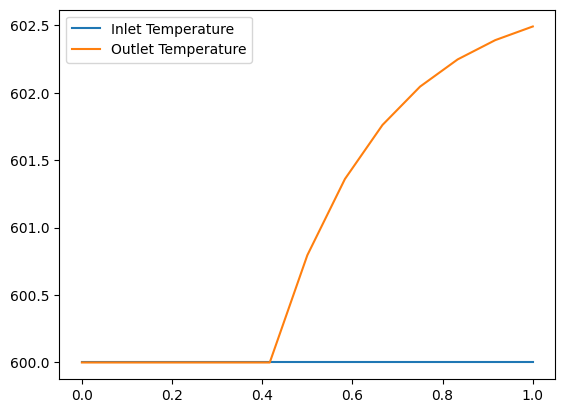

In [1]:
import pyomo.environ as pyo
from idaes.core import FlowsheetBlock
from idaes.models.unit_models import Heater
from idaes.models.properties.general_helmholtz import (
    HelmholtzParameterBlock,
    PhaseType,
    StateVars,
)
from idaes.core.util.model_statistics import degrees_of_freedom
from matplotlib import pyplot as plt

m = pyo.ConcreteModel()
m.fs = FlowsheetBlock(dynamic=True,time_units=pyo.units.s,time_set=[0,1])
m.fs.properties = HelmholtzParameterBlock(
    pure_component="h2o",
    phase_presentation=PhaseType.MIX,
    state_vars=StateVars.TPX,
)
m.fs.heater = Heater(property_package=m.fs.properties,dynamic=True,has_holdup=True,)

@m.fs.heater.Constraint(m.fs.time)
def heat_duty_eq(b, t):
    if t < 0.5:
        return (
            b.heat_duty[t] == 0
        )
    else:
        return (
            b.heat_duty[t] == 10_000
        )


pyo.TransformationFactory("dae.finite_difference").apply_to(
    m.fs, 
    nfe=12, # Number of finite elements to use for discretization 
    wrt=m.fs.time, 
    scheme="BACKWARD"
)

# If we're fixing all the variables, we have to do it after the transformation

m.fs.heater.inlet.flow_mol.fix(100)
m.fs.heater.inlet.temperature.fix(600)
m.fs.heater.inlet.vapor_frac.fix(1)
m.fs.heater.inlet.pressure.fix(101325)
#m.fs.heater.heat_duty.fix(10_000)
m.fs.heater.control_volume.volume.fix(1)

# Fix the derivative variables to zero at time 0 (steady state assumption)
m.fs.fix_initial_conditions()
# or, specify holdup
#m.fs.heater.control_volume.material_holdup[0, 'Mix', 'h2o'].fix(0.001)
#m.fs.heater.control_volume.energy_holdup[0, :].fix(0)
# or, specify accumulation (fix_initial_conditions sets the accumulation to 0)
#m.fs.heater.control_volume.material_accumulation[:, :].fix(300)
#m.fs.heater.control_volume.energy_accumulation[:, :].fix(300)

#print(degrees_of_freedom(m))
solver = pyo.SolverFactory("ipopt")
solver.solve(m)

time = list(m.fs.time)
T_in = [pyo.value(m.fs.heater.inlet.temperature[t]) for t in time]
T_out = [pyo.value(m.fs.heater.outlet.temperature[t]) for t in time]

plt.plot(time, T_in, label="Inlet Temperature")
plt.plot(time, T_out, label="Outlet Temperature")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (K)")
plt.legend()